In [ ]:
!pip install kneed
!pip install pyLDAvis
!pip install pymorphy2

In [1]:
import pandas as pd
import numpy as np

Data Preprocessing
==================
 - df_transform - reorganizes raw chat data into more interpretable format
 - TextPreprocessor - cleans and lemmatizes/stems the messages
 - EM_Pomoshnik_TextPreprocessor - saves and replaces order/shop/incident codes, mentioned in messages

In [2]:
from classes.Preprocessing import df_transform, TextPreprocessor, EM_Pomoshnik_TextPreprocessor

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\McSeem\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
df = df_transform(pd.read_excel('data/empom_autofaq.xlsx'))
df.head()

C:\Users\McSeem\DataspellProjects\EMPom-NLP\classes\Preprocessing.py:28: FutureWarning: The default value of regex will change from True to False in a future version.
  df['user'] = df['Пользователь'].str.replace(r'\n-', '')
C:\Users\McSeem\DataspellProjects\EMPom-NLP\classes\Preprocessing.py:29: FutureWarning: The default value of regex will change from True to False in a future version.
  df['user'] = df['user'].str.replace(r'\n.*', '')
C:\Users\McSeem\DataspellProjects\EMPom-NLP\classes\Preprocessing.py:30: FutureWarning: The default value of regex will change from True to False in a future version.
  df['operators'] = df['Операторы'].str.replace(r'\n', '')
C:\Users\McSeem\DataspellProjects\EMPom-NLP\classes\Preprocessing.py:38: FutureWarning: The default value of regex will change from True to False in a future version.
  df['sender'] = df['sender'].str.replace(r' \(рекомендация\)', '')


,chat_id,channel_type,topics,documents,reaction,bot_confidence,mean_response_time,user,time,sender,sender_name,line
0,88353156-f370-4bca-a979-1d41afef6952,ExtApi,УБЕР,-,-,0.5,0,Андрей Ерохин,03:10:36,user,Андрей Ерохин,"Сбросились роли по спасибо црм, ожидаем обратн..."
0,88353156-f370-4bca-a979-1d41afef6952,ExtApi,УБЕР,-,-,0.5,0,Андрей Ерохин,03:10:37,bot,Бот,Мне не удалось быстро найти ответ. Нужно подож...
0,88353156-f370-4bca-a979-1d41afef6952,ExtApi,УБЕР,-,-,0.5,0,Андрей Ерохин,05:57:17,bot,Бот,"Будут вопросы, пиши."
1,c3e5e5dc-0244-4edb-8cd8-218d356cd3e7,ExtApi,УБЕР,Как изменить магазин в боте,-,0.9,26375,Владимир Слепокуров,03:39:20,user,Владимир Слепокуров,"Заказ 2014345179, 2014358548, 2014358623, 2014..."
1,c3e5e5dc-0244-4edb-8cd8-218d356cd3e7,ExtApi,УБЕР,Как изменить магазин в боте,-,0.9,26375,Владимир Слепокуров,03:39:21,bot,Бот,Мне не удалось быстро найти ответ. Нужно подож...


In [4]:
pomoshnik = EM_Pomoshnik_TextPreprocessor('заказ', 'инцидент', 'магазин')
pomoshnik.fit(df['line'])

df['line'] = pomoshnik.transform()
sw = stopwords.words('Russian')
sw += ['ответ', 'подходит', 'спасибо', 'здравствуйте', 'добрый', 'день', 'мочь', 'подсказать', 'привет', 'заказ',
       'товар', 'клиент', 'могу', 'создать', 'делать', 'сделать', 'который', 'вопрос', 'проблема', 'коллега',
       'помочь', 'пожалуйста']

text = TextPreprocessor(method = 'lemma', replacing_word=' ', stop_words=sw)
text.fit(df['line'])
df['line'] = text.transform()
df['line'].head()

C:\Users\McSeem\DataspellProjects\EMPom-NLP\classes\Preprocessing.py:123: FutureWarning: The default value of regex will change from True to False in a future version.
  self.data = self.data.str.replace(r'\d\d\d\d\d\d\d\d\d\d', self.replacing_order)
C:\Users\McSeem\DataspellProjects\EMPom-NLP\classes\Preprocessing.py:124: FutureWarning: The default value of regex will change from True to False in a future version.
  self.data = self.data.str.replace(r'\d\d\d\d\d\d\d\d\d', self.replacing_order)
C:\Users\McSeem\DataspellProjects\EMPom-NLP\classes\Preprocessing.py:136: FutureWarning: The default value of regex will change from True to False in a future version.
  self.data = self.data.str.replace(r'\d\d-\d\d\d\d\d\d\d\d', self.replacing_incident)
C:\Users\McSeem\DataspellProjects\EMPom-NLP\classes\Preprocessing.py:130: FutureWarning: The default value of regex will change from True to False in a future version.
  self.data = self.data.str.replace(r'[a-zA-Z][a-zA-Z]\d\d', self.replacing_s

0    сброситься роль црм ожидать обратный присвоени...
0     удаться быстро найти нужно подождать пока уто...
0                                               писать
1    отображаться магазин часы работать связь графи...
1     удаться быстро найти нужно подождать пока уто...
Name: line, dtype: object

In [5]:
user_messages = df[df['sender'] == 'user']
nonempty = user_messages[user_messages['line'] != '']
big_enough = nonempty[nonempty['line'].apply(lambda x: len(x.split())) >= 2]
big_enough['line'].shape

(10213,)

Vectorization
=============

In [6]:
from classes.UniVectorizer import Vectorizer

vect = Vectorizer('tfidf', ngram_range=(1, 2), min_df=0.01, max_df=0.9)
X = vect.fit_transform(big_enough['line'])

Clustering
==========

  0%|          | 0/48 [00:00<?, ?it/s]

<Figure size 360x360 with 0 Axes>

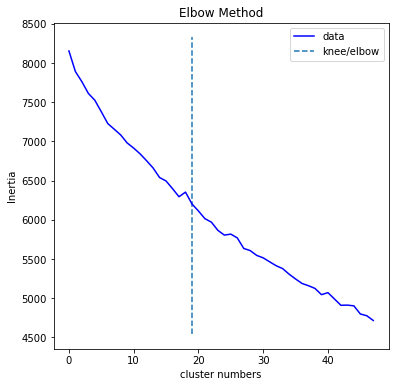

In [8]:
from auxiliary.Insight import optimize_n_clusters, cluster_sizes, get_top_features

n = optimize_n_clusters(X)

In [8]:
from sklearn.cluster import KMeans
from auxiliary.Insight import optimize_n_clusters, cluster_sizes, get_top_features

km = KMeans(n_clusters=n, random_state=1337)
km.fit(X)
print(cluster_sizes(km.labels_))

{2: 5393, 3: 636, 13: 450, 16: 182, 5: 268, 11: 428, 6: 306, 10: 201, 17: 217, 9: 216, 8: 234, 0: 257, 15: 263, 4: 260, 12: 118, 1: 196, 18: 204, 7: 161, 14: 223}


In [14]:
get_top_features(X, km.labels_, 3, vect.get_feature_names())

['магазин', 'наш', 'инцидент', 'остаток', 'склад', 'сотрудник']

In [17]:
from auxiliary.Visualization import kmeans_vis

kmeans_vis(X, km, vect.get_feature_names(), 'kmeans_vis.html')

C:\Users\McSeem\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
C:\Users\McSeem\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:691: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


In [19]:
cluster_labels = []
for i in range(19):
    cluster_labels.append(get_top_features(X, km.labels_, i, vect.get_feature_names())[0])
cluster_labels

C:\Users\McSeem\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['резерв',
 'номер',
 'чек',
 'магазин',
 'ошибка',
 'тн',
 'заявка',
 'промокод',
 'курьер',
 'карта',
 'обмен',
 'доставка',
 'ссылка',
 'возврат',
 'инструкция',
 'код',
 'товарный',
 'выдача',
 'нужный']

In [20]:
big_enough['label'] = km.labels_
big_enough['label'] = big_enough['label'].apply(lambda x: cluster_labels[x])
big_enough['label']

C:\Users\McSeem\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-20-885c17167e3a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  big_enough['label'] = km.labels_
<ipython-input-20-885c17167e3a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

0           чек
1           чек
1       магазин
2       магазин
3       магазин
         ...   
7316        чек
7316        чек
7316        чек
7316        чек
7317     курьер
Name: label, Length: 10213, dtype: object

Sentiment Analysis
==================

In [23]:
!pip install transformers
!pip install torch

C:\Users\McSeem\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
from auxiliary.Sentiment import get_sentiments

In [28]:
lines = big_enough['line'].to_list()
results = get_sentiments(lines)

C:\Users\McSeem\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


  0%|          | 0/1022 [00:00<?, ?it/s]

In [32]:
big_enough['sentiment'] = results

C:\Users\McSeem\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-32-d1ce3169226b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  big_enough['sentiment'] = results


In [34]:
big_enough.to_excel('labelled_messages.xlsx')

C:\Users\McSeem\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
